In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# For balancing the dataset
from imblearn.combine import SMOTEENN

# For modeling - using Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve,
    cohen_kappa_score, matthews_corrcoef, classification_report
)

# Setting random state for reproducibility
RANDOM_STATE = 42

In [2]:
# Load the dataset
file_path = '/home/bolt/Desktop/ml_projects/stroke_risk_prediction/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows:")
print(df.head())

# Check basic information
print("\nDataset info:")
print(df.info())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for 'N/A' values that might not be detected as null
print("\nChecking for 'N/A' values:")
for column in df.columns:
    if df[column].dtype == object:
        na_count = df[column].astype(str).str.contains('N/A').sum()
        if na_count > 0:
            print(f"Column {column} has {na_count} 'N/A' values")

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check class distribution
print("\nTarget variable distribution:")
print(df['stroke'].value_counts())
print(f"Percentage of stroke cases: {df['stroke'].mean()*100:.2f}%")

First 5 rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  

Dataset info:
<class 'pandas.core.frame.D

In [3]:
# Data cleaning
# Convert 'N/A' to NaN in BMI column
df['bmi'] = df['bmi'].replace('N/A', np.nan)

# Convert to numeric
df['bmi'] = pd.to_numeric(df['bmi'], errors='coerce')

# Impute missing values with median (as requested)
df['bmi'] = df['bmi'].fillna(df['bmi'].median())

# Encode categorical variables
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Create a copy for preprocessing
df_encoded = df.copy()

# Apply label encoding to categorical columns
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le
    print(f"Encoding for {column}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Drop the ID column as it's not useful for prediction
df_encoded = df_encoded.drop('id', axis=1)

# Display the encoded data
print("\nEncoded data:")
print(df_encoded.head())

Encoding for gender: {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
Encoding for ever_married: {'No': np.int64(0), 'Yes': np.int64(1)}
Encoding for work_type: {'Govt_job': np.int64(0), 'Never_worked': np.int64(1), 'Private': np.int64(2), 'Self-employed': np.int64(3), 'children': np.int64(4)}
Encoding for Residence_type: {'Rural': np.int64(0), 'Urban': np.int64(1)}
Encoding for smoking_status: {'Unknown': np.int64(0), 'formerly smoked': np.int64(1), 'never smoked': np.int64(2), 'smokes': np.int64(3)}

Encoded data:
   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             1          2   
1       0  61.0             0              0             1          3   
2       1  80.0             0              1             1          2   
3       0  49.0             0              0             1          2   
4       0  79.0             1              0             1          3   

   Residence_type  av

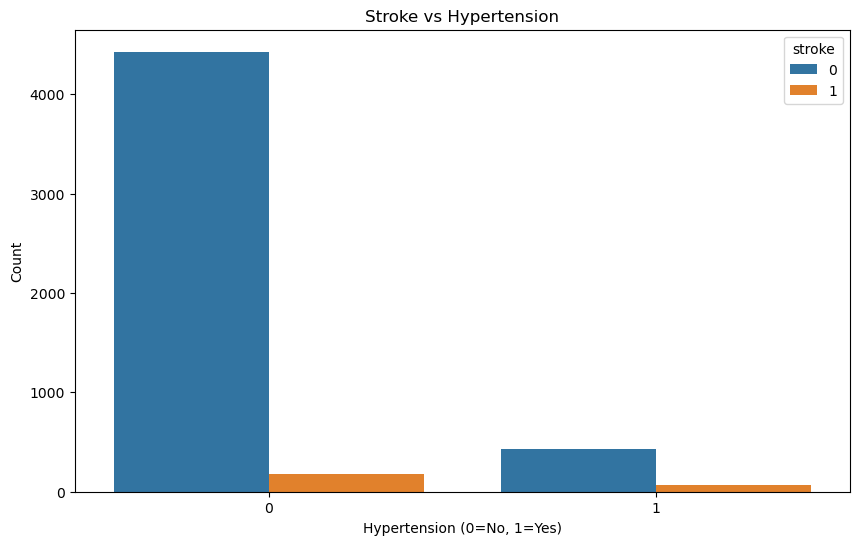

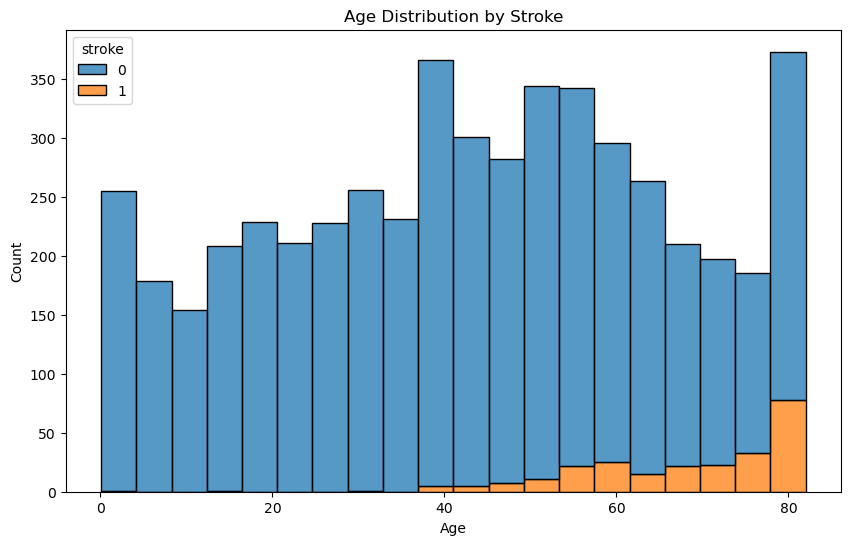

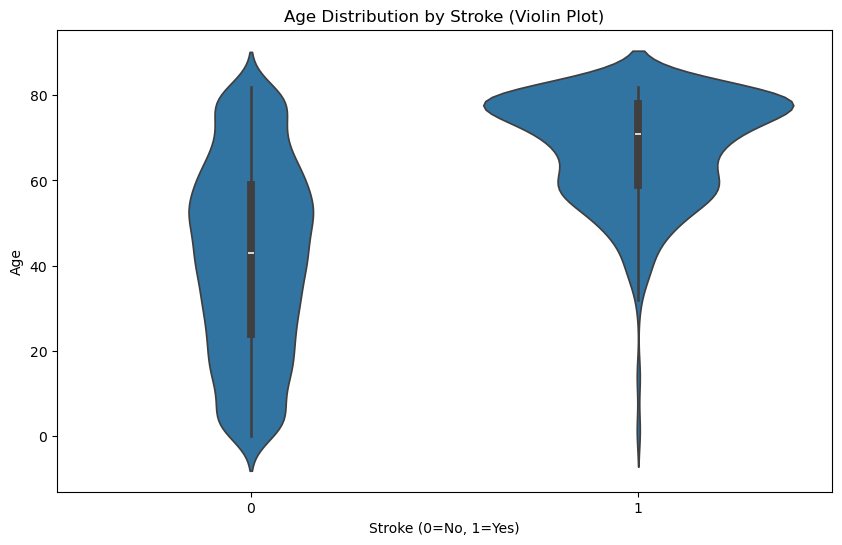

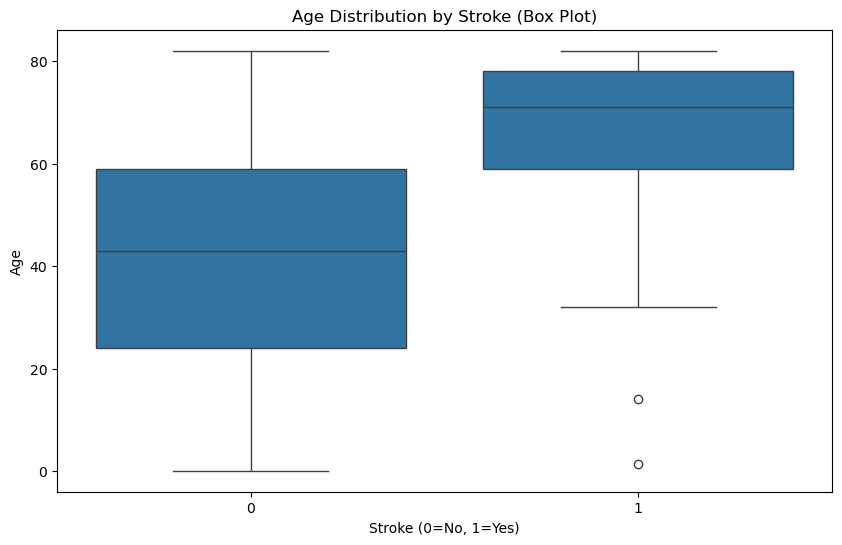

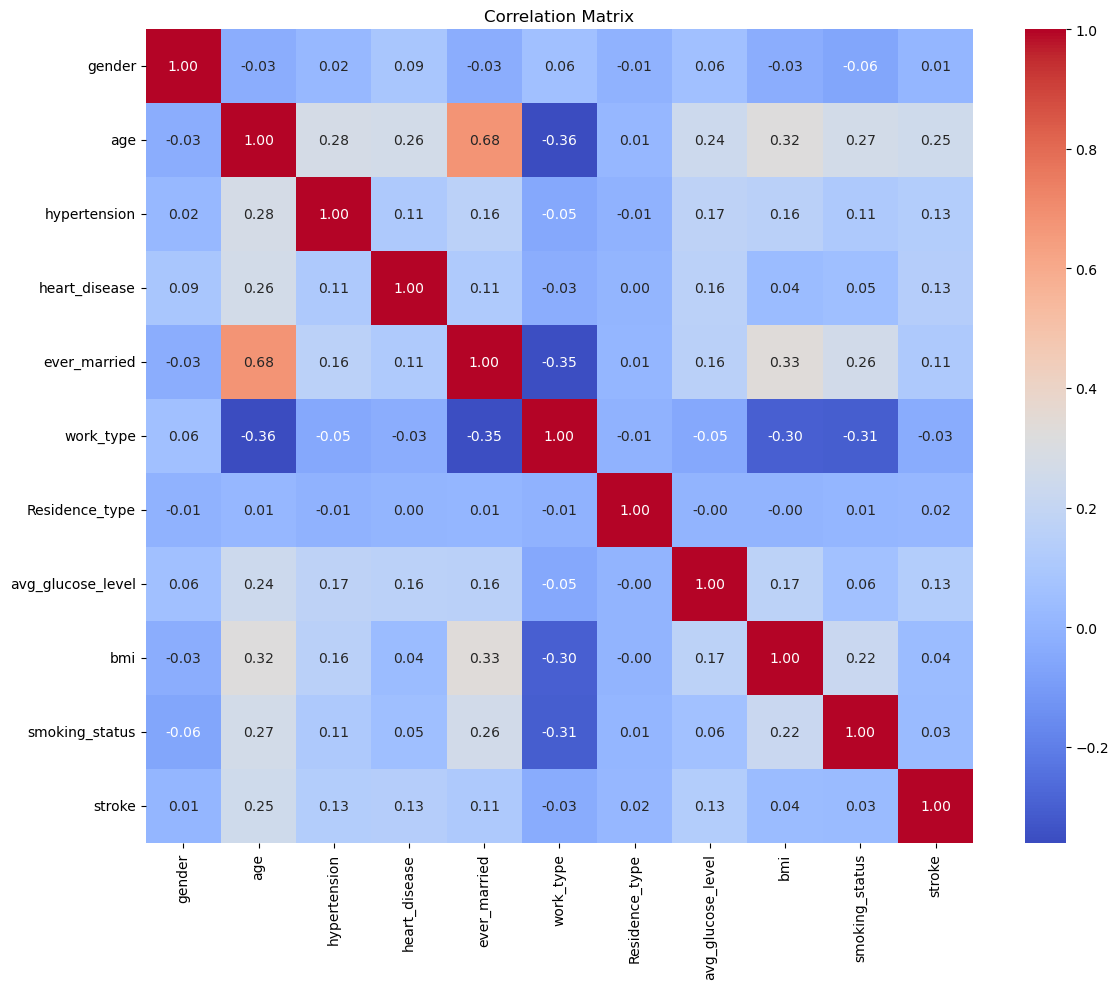

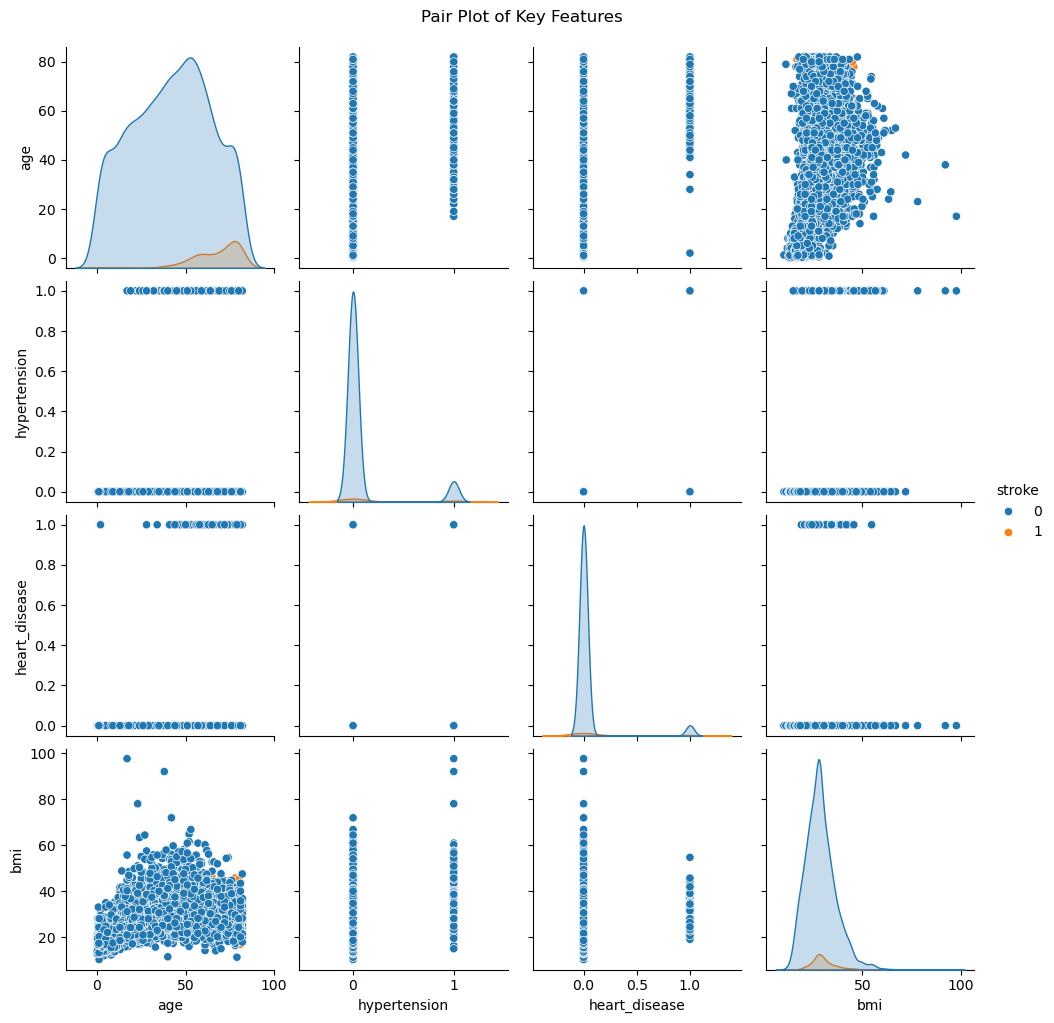

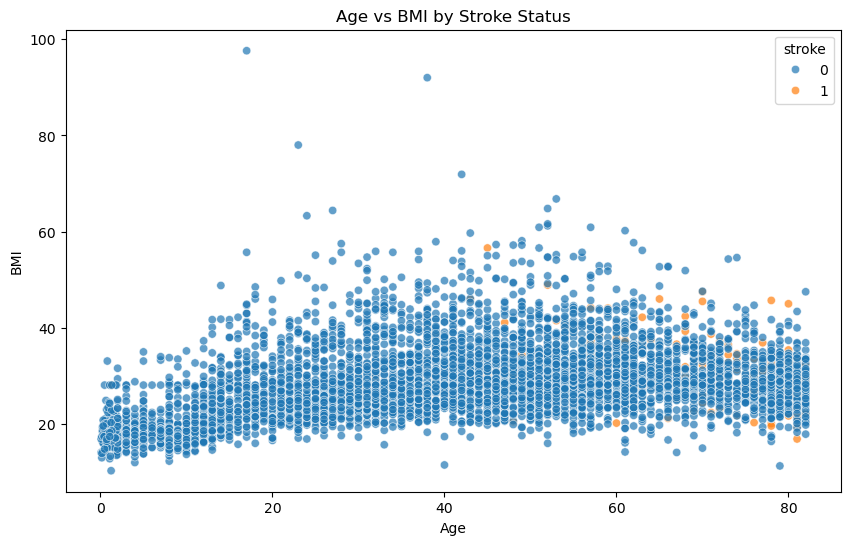

In [4]:
# 1. Stroke and Hypertension
plt.figure(figsize=(10, 6))
sns.countplot(x='hypertension', hue='stroke', data=df)
plt.title('Stroke vs Hypertension')
plt.xlabel('Hypertension (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# 2. Histogram: Age Distribution by Stroke
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', multiple='stack', bins=20)
plt.title('Age Distribution by Stroke')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 3. Violin Plot: Age by Stroke
plt.figure(figsize=(10, 6))
sns.violinplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke (Violin Plot)')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Age')
plt.show()

# 4. Box Plot: Age by Stroke
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='age', data=df)
plt.title('Age Distribution by Stroke (Box Plot)')
plt.xlabel('Stroke (0=No, 1=Yes)')
plt.ylabel('Age')
plt.show()

# 5. Correlation Heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# 6. Pair Plot 
sns.pairplot(df_encoded[['age', 'hypertension', 'heart_disease', 'bmi', 'stroke']], 
             hue='stroke', height=2.5)
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

# 7. Scatter Plot: Age vs BMI with stroke coloring
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='bmi', hue='stroke', alpha=0.7)
plt.title('Age vs BMI by Stroke Status')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

In [5]:
# Define features and target
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

# Check class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in testing set:")
print(y_test.value_counts())

Training set: 4088 samples
Testing set: 1022 samples

Class distribution in training set:
stroke
0    3889
1     199
Name: count, dtype: int64

Class distribution in testing set:
stroke
0    972
1     50
Name: count, dtype: int64


In [6]:
# Apply SMOTEENN to handle class imbalance
smoteenn = SMOTEENN(random_state=RANDOM_STATE)
X_train_balanced, y_train_balanced = smoteenn.fit_resample(X_train, y_train)

print("\nAfter SMOTEENN:")
print(f"Balanced training set: {X_train_balanced.shape[0]} samples")
print("Class distribution in balanced training set:")
print(pd.Series(y_train_balanced).value_counts())


After SMOTEENN:
Balanced training set: 6610 samples
Class distribution in balanced training set:
stroke
1    3669
0    2941
Name: count, dtype: int64


In [7]:
# For Gaussian Naive Bayes, we'll tune var_smoothing
# var_smoothing controls the stability and prevents overfitting
var_smoothing_value = 1e-8  # More smoothing than default (1e-9)

# Train the model and record training time
start_time = time.time()
model = GaussianNB(var_smoothing=var_smoothing_value)
model.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time

print(f"Using var_smoothing = {var_smoothing_value}")
print(f"\nTraining time: {training_time:.4f} seconds")

Using var_smoothing = 1e-08

Training time: 0.0106 seconds


In [8]:
# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob),
    'Cohen\'s Kappa': cohen_kappa_score(y_test, y_pred),
    'Matthews Correlation Coefficient': matthews_corrcoef(y_test, y_pred),
    'Training Time (seconds)': training_time
}

# Display metrics in a table
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])
print("\nModel Performance Metrics:")
print(metrics_df)

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Performance Metrics:
                             Metric     Value
0                          Accuracy  0.681018
1                         Precision  0.107955
2                            Recall  0.760000
3                          F1 Score  0.189055
4                           ROC-AUC  0.806687
5                     Cohen's Kappa  0.113064
6  Matthews Correlation Coefficient  0.198356
7           Training Time (seconds)  0.010605

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       972
           1       0.11      0.76      0.19        50

    accuracy                           0.68      1022
   macro avg       0.55      0.72      0.50      1022
weighted avg       0.94      0.68      0.77      1022



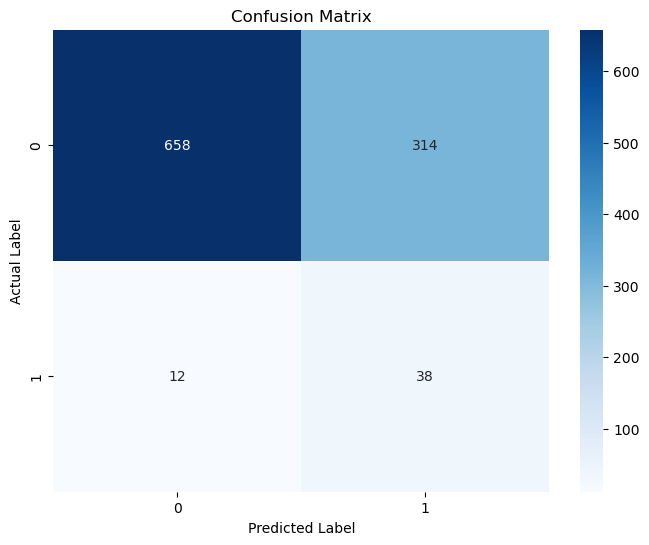

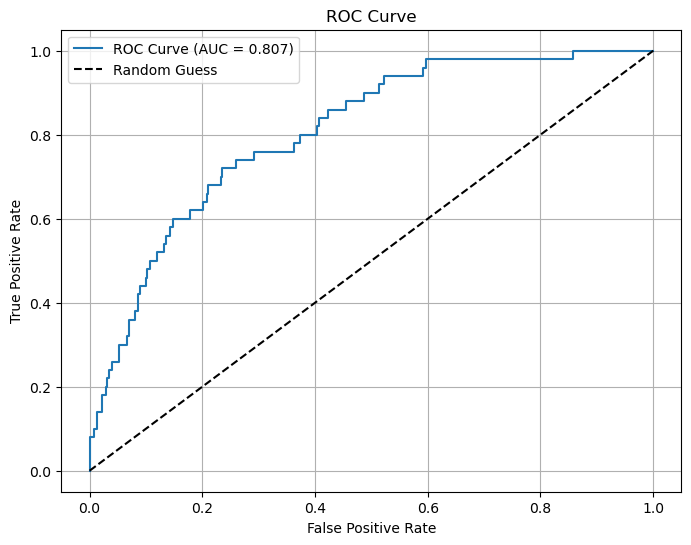

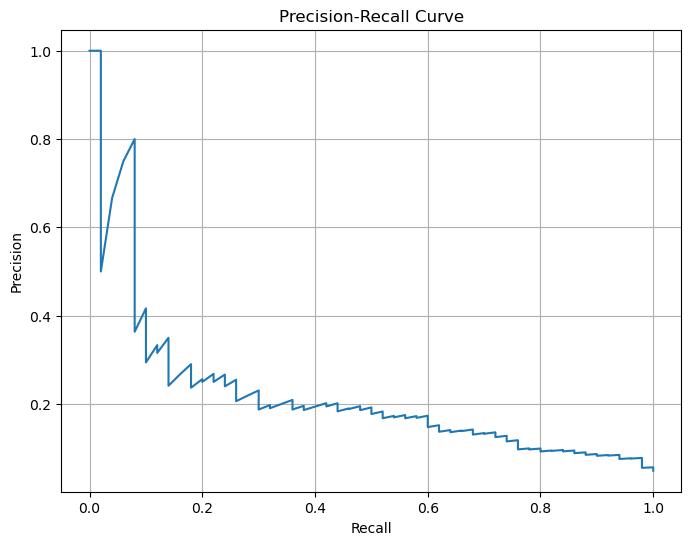

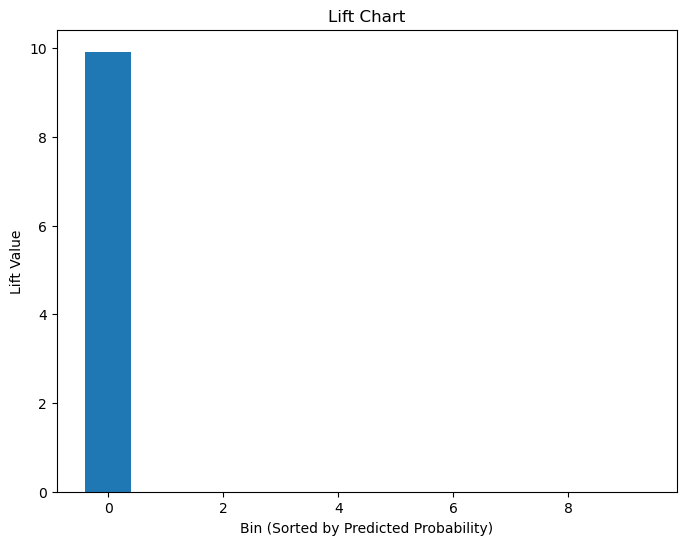

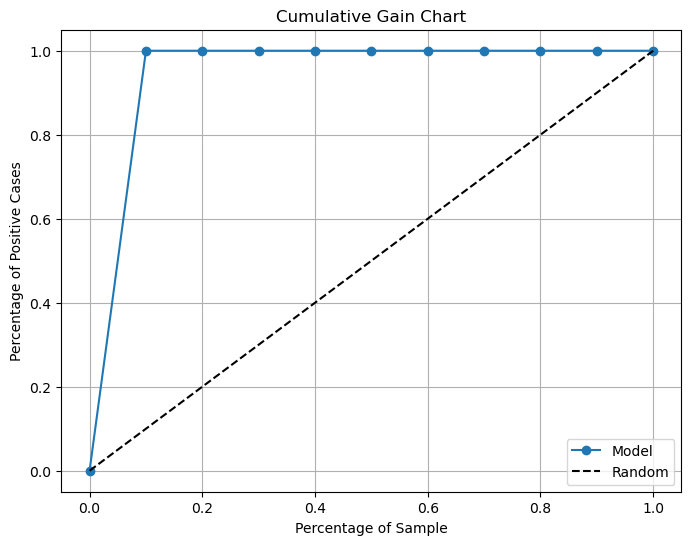

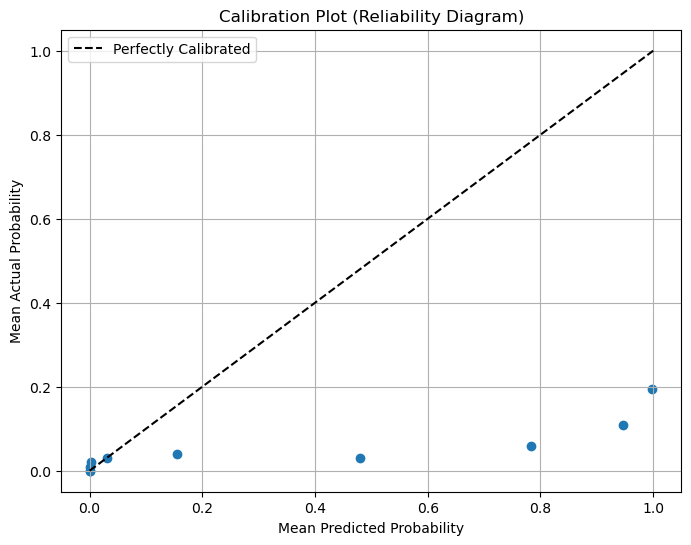

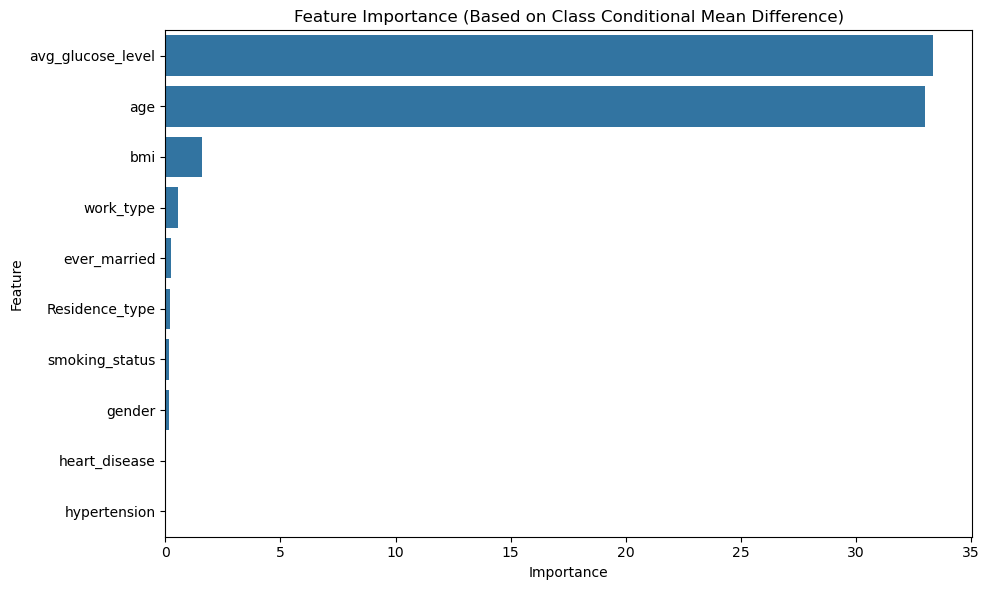

In [9]:
# 1. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 2. ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["ROC-AUC"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# 3. Precision-Recall Curve
plt.figure(figsize=(8, 6))
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# 4. Lift Chart
def calculate_lift(y_true, y_prob, bins=10):
    df = pd.DataFrame({'target': y_true, 'probability': y_prob})
    df = df.sort_values(by='probability', ascending=False)
    df['bin'] = pd.qcut(df.index, q=bins, labels=False)
    lift_values = []
    for i in range(bins):
        bin_df = df[df['bin'] == i]
        lift = bin_df['target'].mean() / y_true.mean()
        lift_values.append(lift)
    return lift_values

lift_values = calculate_lift(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.bar(range(len(lift_values)), lift_values)
plt.xlabel('Bin (Sorted by Predicted Probability)')
plt.ylabel('Lift Value')
plt.title('Lift Chart')
plt.show()

# 5. Gain Chart
def calculate_cumulative_gain(y_true, y_prob, bins=10):
    df = pd.DataFrame({'target': y_true, 'probability': y_prob})
    df = df.sort_values(by='probability', ascending=False)
    total_positive = df['target'].sum()
    df['bin'] = pd.qcut(df.index, q=bins, labels=False)
    cumulative_gains = []
    bin_pcts = []
    cumulative_positives = 0
    
    for i in range(bins):
        bin_df = df[df['bin'] == i]
        cumulative_positives += bin_df['target'].sum()
        cumulative_gains.append(cumulative_positives / total_positive)
        bin_pcts.append((i + 1) / bins)
    
    # Add the origin point
    cumulative_gains.insert(0, 0)
    bin_pcts.insert(0, 0)
    
    return cumulative_gains, bin_pcts

cum_gains, bin_pcts = calculate_cumulative_gain(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(bin_pcts, cum_gains, marker='o', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Percentage of Sample')
plt.ylabel('Percentage of Positive Cases')
plt.title('Cumulative Gain Chart')
plt.legend()
plt.grid(True)
plt.show()

# 6. Calibration Plot
def calculate_calibration(y_true, y_prob, bins=10):
    df = pd.DataFrame({'target': y_true, 'probability': y_prob})
    df = df.sort_values(by='probability')
    df['bin'] = pd.qcut(df['probability'], q=bins, labels=False, duplicates='drop')
    
    mean_predicted_probs = []
    mean_actual_probs = []
    
    for i in sorted(df['bin'].unique()):
        bin_df = df[df['bin'] == i]
        if not bin_df.empty:
            mean_predicted_probs.append(bin_df['probability'].mean())
            mean_actual_probs.append(bin_df['target'].mean())
    
    return mean_predicted_probs, mean_actual_probs

mean_predicted_probs, mean_actual_probs = calculate_calibration(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.scatter(mean_predicted_probs, mean_actual_probs)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Mean Actual Probability')
plt.title('Calibration Plot (Reliability Diagram)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate feature importance for Naive Bayes
# For Gaussian NB, the difference between class means can indicate feature importance
feature_importance = np.abs(model.theta_[1] - model.theta_[0])
feature_names = X.columns

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Feature Importance (Based on Class Conditional Mean Difference)')
plt.tight_layout()
plt.show()

In [10]:
# Save the model using joblib
model_path = '/home/bolt/Desktop/ml_projects/stroke_risk_prediction/trained_models/naive_bayes_stroke_model.joblib'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: /home/bolt/Desktop/ml_projects/stroke_risk_prediction/trained_models/naive_bayes_stroke_model.joblib
